<a href="https://colab.research.google.com/github/rae-fahrenholtz/nyc-airbnb/blob/main/NYC_Airbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## Overview

For this analysis, I will be using Airbnb prices in New York City in 2019. Initially, this data set comes from a public API through Airbnb. However, for this study, I will be using a clean data set from Kaggle, found at www.kaggle.com/dgomonov/new-york-city-airbnb-open-data. 

Some areas of interest in this data set include prices, room type, and neighborhood groups. My goal is that with this information, I will be able to help potential travelers make quick rental decisions given their budget and need for proximity to downtown. 

## Research Questions

For Airbnb rentals in 2019 in New York City: 

1. Is the average rental price significantly different for different room types?
2. Is the average rental price significantly different in different neighborhoods?
3. Is the average rental price for different neighborhoods and room types combinations significantly different?


## Research Design

I will test these hypotheses with parametric tests, including t-tests and F-tests, and non-parametric tests, including the median test and Kruskal-Wallis one-way analysis of variance. In addition, I will include tests to check for violations of test assumptions for the parametric tests. 

Intuitively, we would expect different room types to have different rental prices, but we will test this statistically. We would also expect other neighborhoods to have different rental prices -- staying in the heart of the big apple will likely come at a premium!

The final hypothesis could be helpful for potential travelers planning on visiting NYC. Given that a traveler has flexible plans on where they would like to stay within NYC and what kind of room they would like, we could save the traveler time in booking a reservation by informing them what combinations of neighborhood and room type are statistically similar.


# Analysis

## EDA

In [ ]:
#general
import pandas as pd
import numpy as np

#plot
import matplotlib.pyplot as plt
import seaborn as sns 

#stats
from scipy import stats
import math
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
pd.options.mode.chained_assignment = None  #default='warn'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load Data

To load data from the Kaggle API, you will need a `kaggle.json` file that includes your API credentials. 

For an example `kaggle.json` file, see `ex_kaggle.json` in the [github repo](https://github.com/rae-fahrenholtz/nyc-airbnb)

> To find your `kaggle.json` file, go to your user profile's 'Account' tab and select 'Create API Token'. This will trigger the download of kaggle.json, a file containing your API credentials.

In [ ]:
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"raefahrenholtz","key":"759a14494c6f1568ca61e840b8c48259"}'}

In [ ]:
#upload data from Kaggle API into colab
!pip install -q kaggle #-q flag; quiet, less output
!mkdir -p ~/.kaggle #-p flag; no error if existing
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json #set permission

In [ ]:
#download data from Kaggle
!kaggle datasets download dgomonov/new-york-city-airbnb-open-data
!unzip new-york-city-airbnb-open-data.zip #unzip data

  0% 0.00/2.44M [00:00<?, ?B/s]
100% 2.44M/2.44M [00:00<00:00, 180MB/s]
Archive:  new-york-city-airbnb-open-data.zip
  inflating: AB_NYC_2019.csv         
  inflating: New_York_City_.png      


In [ ]:
#import csv as pandas dataframe
df = pd.read_csv('AB_NYC_2019.csv')

### Initial Look at the Data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

For this analysis, we are interested in `price` in relation to `room_type` and `neighbourhood_group`.

In [ ]:
pd.concat([df['price'], df['room_type'], df['neighbourhood_group']], axis=1).head(7)

,price,room_type,neighbourhood_group
0,149,Private room,Brooklyn
1,225,Entire home/apt,Manhattan
2,150,Private room,Manhattan
3,89,Entire home/apt,Brooklyn
4,80,Entire home/apt,Manhattan
5,200,Entire home/apt,Manhattan
6,60,Private room,Brooklyn


In [ ]:
#checking size of data set
count = df['price'].count()
print("Total Entries: {}".format(count))

Total Entries: 48895


In [ ]:
print('price:')
round(df['price'].describe(),2)

price:


count    48895.00
mean       152.72
std        240.15
min          0.00
25%         69.00
50%        106.00
75%        175.00
max      10000.00
Name: price, dtype: float64

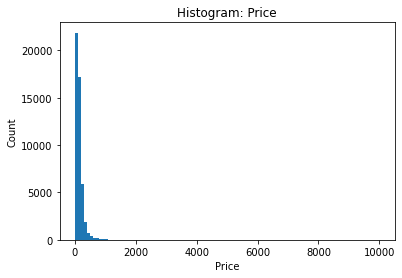

In [ ]:
plt.hist(df['price'], bins=100)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Histogram: Price')
plt.show()

- Presense of high outliers, and right-skew distribution

In [ ]:
print('room_types:')
print(df['room_type'].unique(), '\n')
print('counts:')
print(df.groupby('room_type').size())

room_types:
['Private room' 'Entire home/apt' 'Shared room'] 

counts:
room_type
Entire home/apt    25409
Private room       22326
Shared room         1160
dtype: int64


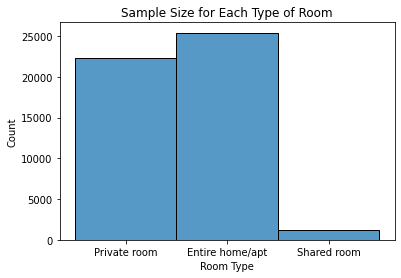

In [ ]:
sns.histplot(df['room_type'])
plt.title('Sample Size for Each Type of Room')
plt.xlabel('Room Type')
plt.ylabel("Count")
plt.show()

In [ ]:
print('neighbourhood_groups:')
print(df['neighbourhood_group'].unique(),'\n')
print('counts:')
print(df.groupby('neighbourhood_group').size())

neighbourhood_groups:
['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx'] 

counts:
neighbourhood_group
Bronx             1091
Brooklyn         20104
Manhattan        21661
Queens            5666
Staten Island      373
dtype: int64


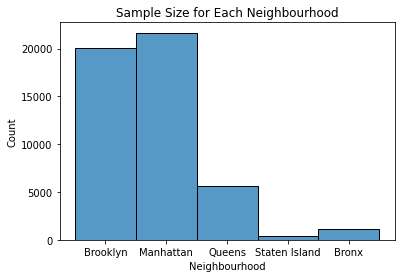

In [ ]:
sns.histplot(df['neighbourhood_group'])
plt.title('Sample Size for Each Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel("Count")
plt.show()

- Unbalanced groups for `room_type` and `neighbourhood_groups`

In [ ]:
#Check for missing values
cols = ['price','room_type','neighbourhood_group']

for col in cols:
  null_count = df[col].isnull().sum()
  print("Number of Missing Values for {}: {}".format(col, null_count))

Number of Missing Values for price: 0
Number of Missing Values for room_type: 0
Number of Missing Values for neighbourhood_group: 0


- No missing values for variables of interest

###Data Preparation

We will need data that is approximately normally distributed for our parametric tests. Let's look at the variable `price` for normality.

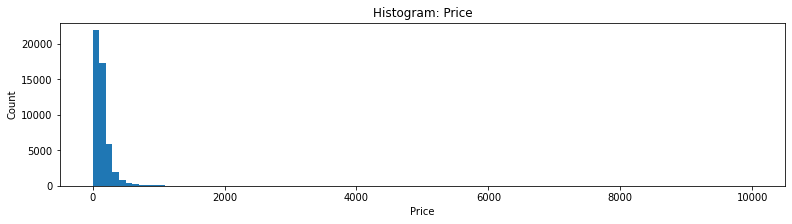

In [ ]:
plt.figure(figsize=(13,3))
plt.hist(df['price'], bins=100)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Histogram: Price')
plt.show()

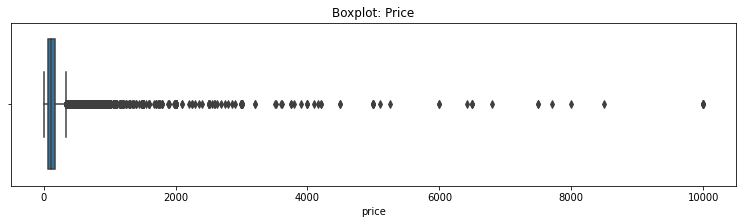

In [ ]:
plt.figure(figsize=(13,3))
sns.boxplot(data=df, x='price')
plt.title('Boxplot: Price')
plt.show()

In [ ]:
print('Descriptive Statistics for Price:', '\n')
print('mean: {:.2f}'.format(stats.describe(df['price'])[2]))
print('variance: {:.2f}'.format(stats.describe(df['price'])[3]))
print('skewness: {:.2f}'.format(stats.describe(df['price'])[4]))
print('kurtosis: {:.2f}'.format(stats.describe(df['price'])[5]))

Descriptive Statistics for Price: 

mean: 152.72
variance: 57674.03
skewness: 19.12
kurtosis: 585.61


- Visually this is not normally distributed 
- Presence of large outliers
- Large skew and kurtosis also show lack of normality

Consider a log transformation of price. 

First, we remove entries where `price == 0`. The domain for the log function is positive real numbers (does not include zero). Realistically, we are only interested in rental prices that are not free.

In [ ]:
#entries where price==0 
zeros = df[df['price'] == 0]    
#check to see how many entires were removed
nzero = zeros['price'].count()
print("{} entries will be removed, where price is zero".format(nzero))
print("{:.2f}% of total entries will be removed, where the price is zero".format
      ((nzero/df.shape[0])*100)
      )

11 entries will be removed, where price is zero
0.02% of total entries will be removed, where the price is zero


In [ ]:
#remove entries where price==0
df_clean = df[df['price'] !=0]

#calculate logorithm on 'price'
df_clean.loc[:,'log_price'] = np.log10(df_clean.loc[:,'price'])

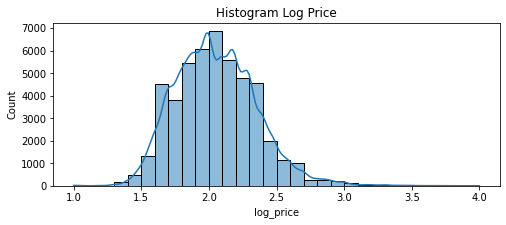

In [ ]:
plt.figure(figsize=(8,3))
sns.histplot(data=df_clean, x='log_price', kde=True, bins=30)
plt.title('Histogram Log Price')
plt.show()

In [ ]:
print('Descriptive Statistics for Log Price:', '\n')
print('mean: {:.2f}'.format(stats.describe(df_clean['log_price'])[2]))
print('variance: {:.3f}'.format(stats.describe(df_clean['log_price'])[3]))
print('skewness: {:.2f}'.format(stats.describe(df_clean['log_price'])[4]))
print('kurtosis: {:.2f}'.format(stats.describe(df_clean['log_price'])[5]))

Descriptive Statistics for Log Price: 

mean: 2.05
variance: 0.092
skewness: 0.61
kurtosis: 1.30


- Visually, the transformed distribution looks much more normal
- The suggested rule of thumb that $|Skew| < 3$  and $|Kurtosis| < 8$ are both satisfied

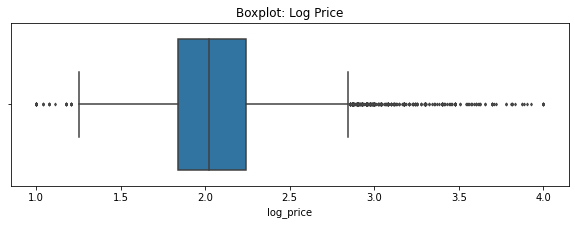

In [ ]:
plt.figure(figsize=(10,3))
sns.boxplot(data=df_clean, x='log_price', 
            #changes size of markers outside IQR
            flierprops = dict(markerfacecolor = '0.50', markersize = 2))
plt.title('Boxplot: Log Price')
plt.show()

- After transformation, there is a presence of some potential outliers for high rental prices 

In [ ]:
#define outlier threshold; 4 std above the mean
mu = df_clean['log_price'].mean()
std = df_clean['log_price'].std()
four_std_thres = 4*std + mu

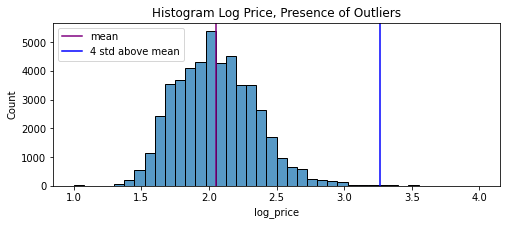

In [ ]:
plt.figure(figsize=(8,3))
sns.histplot(data=df_clean, x='log_price', bins=40)
plt.title('Histogram Log Price, Presence of Outliers')
plt.axvline(x=mu, color='purple')
plt.axvline(x=four_std_thres, color='blue')
plt.legend(labels=['mean', '4 std above mean'])
plt.show()

In [ ]:
#number of entries where log price>=four_std_thres
noutlier = df_clean['log_price'][df_clean['log_price'] 
                                 >= four_std_thres].count()    

print(
'''{} entries have a log price greater 
than 4 standard deviations above the mean \n'''
.format(noutlier)
)

print(
'''{:.2f}% of total entries have a log price greater 
than four standard deviations above the mean '''
.format((noutlier/df.shape[0]*100))
)

117 entries have a log price greater 
than 4 standard deviations above the mean 

0.24% of total entries have a log price greater 
than four standard deviations above the mean 


Outliers; To remove or not to remove, that is the question. 

In [ ]:
#entries larger than four standard deviations above the mean
outliers = df_clean[df_clean['log_price'] >= four_std_thres]

print('Number of Outliers per Neighbourhood: \n')
print(outliers.groupby('neighbourhood_group').count()['log_price'], 
      '\n \n' '--------------------- \n')

print('Number of Outliers per Room type: \n')
print(outliers.groupby('room_type').count()['log_price'])

Number of Outliers per Neighbourhood: 

neighbourhood_group
Bronx             1
Brooklyn         25
Manhattan        85
Queens            5
Staten Island     1
Name: log_price, dtype: int64 
 
--------------------- 

Number of Outliers per Room type: 

room_type
Entire home/apt    95
Private room       22
Name: log_price, dtype: int64


I will remove outliers defined as four standard deviations above the mean for the remainder of the analysis. My justification is that: 

- This removes less than 0.25% of total entries 
- Our target audience is potential travelers to NYC considering different room types and neighbourhoods. Most outliers are luxury rentals in Manhattan, renting the entire home/apt, which is not the most representative for our target audience.

In [ ]:
#df_airbnb has price==0 and outliers 4 std above the mean removed
df_airbnb = df_clean[df_clean['log_price'] < four_std_thres]

In [ ]:
df_airbnb.shape

(48767, 17)

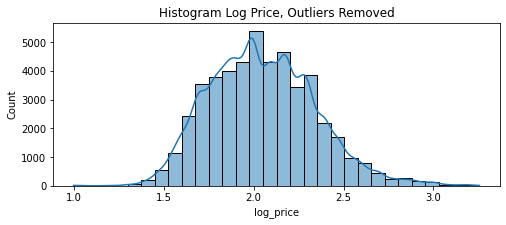

In [ ]:
plt.figure(figsize=(8,3))
sns.histplot(data=df_airbnb, x='log_price', kde=True, bins=30)
plt.title('Histogram Log Price, Outliers Removed')
plt.show()

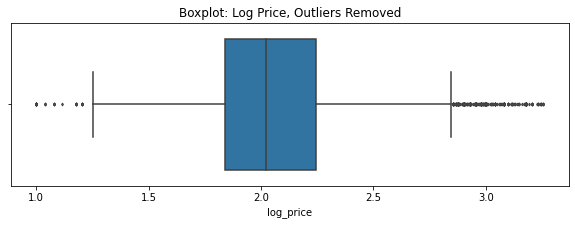

In [ ]:
plt.figure(figsize=(10,3))
sns.boxplot(data=df_airbnb, x='log_price', 
            #changes size of markers outside IQR
            flierprops = dict(markerfacecolor = '0.50', markersize = 2))
plt.title('Boxplot: Log Price, Outliers Removed')
plt.show()

## Testing

### Research Question 1: Comparison of *Room Types*

#### Introduction

Research Question:
> Is there a statistically significant difference in the average daily rental price for Airbnb rentals in NYC in 2019 for a private room rentals versus an entire home rental? 

I will be using the variable `room_type` for A/B testing, where: 

*   Group A: Private Room 
*   Group B: Entire home/apt


Formally,

Null Hypothesis
> $H_0: \mu_A = \mu_B$

Alternative Hypothesis
> $H_1: \mu_A \neq \mu_B$


I would expect that, on average, rentals for the entire home to be more expensive than rentals for just a private room, but I will formally test this hypothesis using a Student's T-test.

Note, I will not consider 'Shared room' rentals because of the relatively smaller sample size.

#####Initial Look at the Data

In [ ]:
#split data set into two groups
df_room = df_airbnb[df_airbnb['room_type'] == 'Private room']
df_home = df_airbnb[df_airbnb['room_type'] == 'Entire home/apt']

In [ ]:
room_count = df_room['log_price'].count()
home_count = df_home['log_price'].count()

print("Total Entries for Private Room Rental: {}".format(room_count))
print("Total Entries for Entire Home Rental: {}".format(home_count))

Total Entries for Private Room Rental: 22297
Total Entries for Entire Home Rental: 25312


- Fairly balanced groups

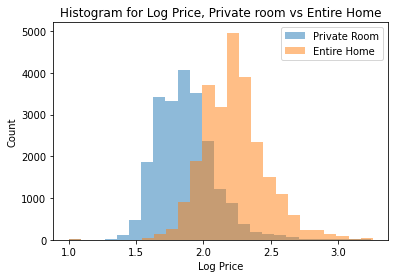

In [ ]:
#plot hist of log_price for private room and entire home/apt
plt.hist(df_room['log_price'], alpha = .5, bins = 25)
plt.hist(df_home['log_price'], alpha = .5, bins = 25)
plt.title("Histogram for Log Price, Private room vs Entire Home")
plt.xlabel("Log Price")
plt.ylabel("Count")
plt.legend(['Private Room','Entire Home'])
plt.show()

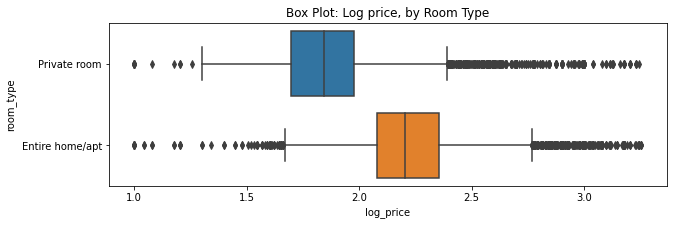

In [ ]:
# Boxplot
fig, ax = plt.subplots(figsize=(10,3))
ax = sns.boxplot(x="log_price", y="room_type", data=df_airbnb, 
                 order=['Private room', 'Entire home/apt'], orient='h')
ax.set_title("Box Plot: Log price, by Room Type")
plt.show()

#### Checking Test Assumptions

Simply, the Student's T-test has three main assumptions:
1.  Independence 
2.  Normality
3.  Homogenous Variance

##### 1. Independence

> Intuitively, we will assume that the assumption for independence is satisfied -- One rental price would not influence other rental prices. However, some hosts have more than one rental, which could lead to some dependence, but we will consider it negligible for the remainder of this analysis.

##### 2. Normality

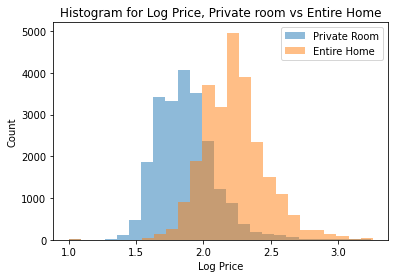

In [ ]:
#plot hist of log_price for room and home together
plt.hist(df_room['log_price'], alpha = .5, bins = 25)
plt.hist(df_home['log_price'], alpha = .5, bins = 25)
plt.title("Histogram for Log Price, Private room vs Entire Home")
plt.xlabel("Log Price")
plt.ylabel("Count")
plt.legend(['Private Room','Entire Home'])
plt.show()

- Visually, each group appears to be approximately normally distrubted

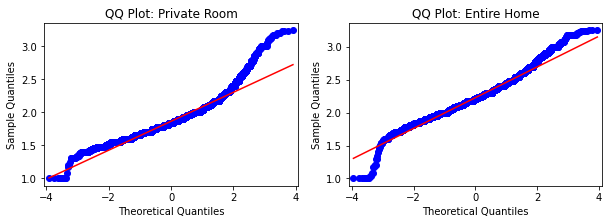

In [ ]:
#qq plots
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=False)
sm.qqplot(df_room['log_price'], line="s",ax=axes[0])
axes[0].set_title('QQ Plot: Private Room')
sm.qqplot(df_home['log_price'], line="s",ax=axes[1])
axes[1].set_title('QQ Plot: Entire Home')
plt.show()

- A QQ plot would follow the red 45-degree line for a theoretically normal distribution
- This data for each group appears to be approximately normal except for the tails of the distribution, which is not unexpected for real-life data



In [ ]:
print('Descriptive Statistics for Log Price, Private Room:', '\n')
print('mean: {:.2f}'.format(stats.describe(df_room['log_price'])[2]))
print('variance: {:.3f}'.format(stats.describe(df_room['log_price'])[3]))
print('skewness: {:.2f}'.format(stats.describe(df_room['log_price'])[4]))
print('kurtosis: {:.2f}'.format(stats.describe(df_room['log_price'])[5]))

Descriptive Statistics for Log Price, Private Room: 

mean: 1.86
variance: 0.048
skewness: 1.16
kurtosis: 3.52


In [ ]:
print('Descriptive Statistics for Log Price, Entire home/apt:', '\n')
print('mean: {:.2f}'.format(stats.describe(df_home['log_price'])[2]))
print('variance: {:.3f}'.format(stats.describe(df_home['log_price'])[3]))
print('skewness: {:.2f}'.format(stats.describe(df_home['log_price'])[4]))
print('kurtosis: {:.2f}'.format(stats.describe(df_home['log_price'])[5]))

Descriptive Statistics for Log Price, Entire home/apt: 

mean: 2.23
variance: 0.055
skewness: 0.54
kurtosis: 1.29


- The suggested rule of thumb that $|Skew| < 3$  and $|Kurtosis| < 8$ are both satisfied for each group

Now, lets formally test for Normality using two tests:

1.   Shapiro–Wilk (SW)
2.   Anderson-Darling (AD)

In [ ]:
#Shapiro-Wilk test
room_SW = stats.shapiro(df_room['log_price'])
home_SW = stats.shapiro(df_home['log_price'])

#Anderson-Darling Test
room_AD = stats.anderson(df_room['log_price'])
home_AD = stats.anderson(df_home['log_price'])

print(
    '''
    Private Room: 
    The SW test statistic is {:.3f} with a p-value of {:.5f}
    '''
    .format(room_SW[0], room_SW[1])
    )

print(
    '''
    Entire Home: 
    The SW test statistic is: {:.3f} with a p-value of {:.5f}
    '''
    .format(home_SW[0], home_SW[1])
    )


    Private Room: 
    The SW test statistic is 0.940 with a p-value of 0.00000
    

    Entire Home: 
    The SW test statistic is: 0.977 with a p-value of 0.00000
    


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


For both groups, we reject normality.

In [ ]:
print("Anderson Darling Test \n")
print("Private Room: \n ")
print("Test Statistic: {:.2f}".format(room_AD.statistic))
print("Critical Values: {}".format(room_AD.critical_values))
print("Significance Levels: {} \n".format((room_AD.significance_level)))
print("--------------------------- \n")
print("Entire home/apt: \n")
print("Test Statistic: {:.2f}".format(home_AD.statistic))
print("Critical Values: {}".format(home_AD.critical_values))
print("Significance Levels: {}".format((home_AD.significance_level)))

Anderson Darling Test 

Private Room: 
 
Test Statistic: 207.95
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ] 

--------------------------- 

Entire home/apt: 

Test Statistic: 122.40
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]


The test statistic is larger than all given critical values, so we reject normality at all given significance levels. 

We reject normality for each group for both the Shapiro-Wilk and Anderson Darling tests. Note that the Shapiro-Wilk test is sensitive to small deviations from normality for large sample sizes.

Even though we statistically rejected normality with the SW and AD tests, we noted previously that the histograms and QQ plots look relatively normal -- we would expect some deviations from normality in real-data situations. We will move forward with the t-test.

##### 3. Homogeneous Variance

We will formally test for equality of variance across groups with two tests:


1.   Barlett's test
2.   Levene test



In [ ]:
#Barlett's test
bartletttest = stats.bartlett(df_room['log_price'], df_home['log_price'])
print(
    '''
    The Barlett test statistic is {:.2f} with a p-value of {:.5f}.
    '''
    .format(bartletttest.statistic, bartletttest.pvalue)
    )


    The Barlett test statistic is 105.96 with a p-value of 0.00000.
    


In [ ]:
#Levene test
#Less senstive to departures from normalitiy than bartlett

levenetest = stats.levene(df_room['log_price'], df_home['log_price'])
print(
    '''
    The Levene test statistic is {:.2f} with a p-value of {:.5f}.
    '''
    .format(levenetest.statistic, levenetest.pvalue)
    )


    The Levene test statistic is 152.43 with a p-value of 0.00000.
    


We reject the hypothesis that the group variances are the same. This violates an assumption of the t-test. However, since the two group look fairly similarly distrituted in the histogram, we will move on with our t-test. 

####Parametric Test


######The t-test

In [ ]:
ttest = stats.ttest_ind(df_home['log_price'], df_room['log_price'])
print(
    '''
    The t-test statistic is {:.2f} with a p-value of {:.5f}.
    '''
    .format(ttest.statistic, ttest.pvalue))


    The t-test statistic is 174.60 with a p-value of 0.00000.
    


We reject the null hypothesis that the average log prices are the same for rentals for the entire house versus a private room. 

Intuitively, we expected the two groups to differ. 

Confidence Interval (CI)

In [ ]:
#Function to calculating (ci_perc)% CI for a difference between two means

#ci_perc: (0,100)

#prints for CI of transformed log data 
#and translation back into into ratio of geometric means

def get_ci(array_1, array_2, ci_perc):
    n1 = array_1.shape[0] #sample size array_1
    n2 = array_2.shape[0] #sample size array_2

    mu1 = array_1.mean() 
    mu2 = array_2.mean() 

    var1 = array_1.var() 
    var2 = array_2.var() 
    
    mu_diff = mu2 - mu1 
    
    #pooled estimate of the common standard deviation 
    std_pooled = math.sqrt((((n1 - 1)*var1) + ((n2 - 1)*var2)) / (n1 + n2 - 2))

    alpha = 1 - (ci_perc/100) #significance level
    df = n1 + n2 - 2 #degrees of freedom
    t_crit = stats.t.ppf((1 - (alpha/2)), df)
    
    margin_err = t_crit*std_pooled*math.sqrt(n1**-1 + n2**-1)

    ci_lower = mu_diff - margin_err
    ci_upper = mu_diff + margin_err

    ratio_lower = 10**ci_lower
    ratio_upper = 10**ci_upper
    ratio_mudiff = 10**mu_diff

    return(
        '''
        The difference in means for the log transformed data at the {:.0f}% 
        confidence interval is between {:.3f} and {:.3f}. \n 

        The geometric mean price of Group 1 is {:.3f} times as much as 
        Group 2 ({}% CI: {:.3f} to {:.3f} times as much). 

        '''
        .format(ci_perc, 
                ci_lower, 
                ci_upper,
                ratio_mudiff,
                ci_perc,
                ratio_lower,
                ratio_upper)
    )

In [ ]:
ci = get_ci(df_room['log_price'], df_home['log_price'], 95)
print(ci)


        The difference in means for the log transformed data at the 95% 
        confidence interval is between 0.360 and 0.368. 
 

        The geometric mean price of Group 1 is 2.311 times as much as 
        Group 2 (95% CI: 2.289 to 2.333 times as much). 

        


####Non Parametric Tests

Since we rejected the assumptions for normality and homogeneous variance, I will consider two non-parametric tests:

1.   Kruskal–Wallis (KW)
2.   Median Test



In [ ]:
#KW
kruskaltest = stats.kruskal(df_room['log_price'], df_home['log_price'])
print("The KW test statistic is {:.2} with a p-value of {:.5}.".format(
    kruskaltest.statistic, kruskaltest.pvalue))

The KW test statistic is 2.1e+04 with a p-value of 0.0.


- We reject the null hypothesis; thus, one sample stochastically dominates another sample. 

In [ ]:
#Median Test
stat, p, med, tbl = stats.median_test(
    df_room['log_price'], 
    df_home['log_price'])
print("The Median test statistic is {:.2} with a p-value of {:.5}.".
      format(stat, p))

The Median test statistic is 1.9e+04 with a p-value of 0.0.


- We reject the null hypothesis that the two samples come from populations with an equal median value.


####Summary

Our findings for the comparisons of Room Types are as follows: 

- T-test: Groups are significantly different
- KW Test: Samples are significantly different
- Median Test: Medians are significantly different 

We confirmed our intuition; the prices for rentals that include the entire home is significantly different from rental prices with a private room. 

### Research Question 2: Comparison of *Neighbourhood Groups*

#### Introduction

Next, let's look at `neighbourhood_groups` to see if there are significantly different prices in different NYC neighbourhoods. Intuitively, we would expect rental costs to differ based on location in NYC.

Research Question:
> Is there a statistically significant difference in the average daily rental price for Airbnb rentals in NYC in 2019 in different neighbourhood groups?

Recall in the exploratory analysis that `neighbourhood_group` is an unbalanced variable. However, since the rental prices in Queens, Bronx, and Staten Island are similarly distributed, seen in the box plot below, I will combine Queens, Bronx, and Staten Island into a single neighbourhood group, `QBS`, to achieve a more balanced grouping for testing.

In [ ]:
#function to recategorize 'neighbourhood_groups' 
def categorize_neighbourhoods(var):
    if var == 'Manhattan':
        return 'Manhattan'
    elif var == 'Brooklyn':
        return 'Brooklyn'
    else:
        return 'QBS'

#use the pandas `apply()` method by calling the function above
df_airbnb['neighbourhood_regroup'] = df_airbnb[
                                               'neighbourhood_group'
                                               ].apply(categorize_neighbourhoods
                                                       )

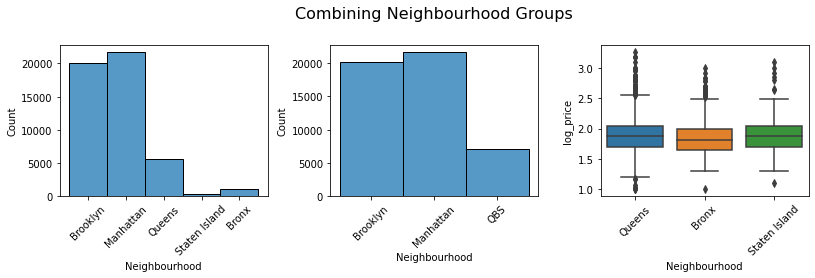

In [ ]:
plt.figure(figsize = (13,3))
plt.suptitle('Combining Neighbourhood Groups', fontsize=16)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.8, 
                    wspace=0.3, 
                    hspace=0.4)

plt.subplot(1,3,1)
sns.histplot(df['neighbourhood_group'])
plt.xticks(rotation = 45)
plt.xlabel('Neighbourhood')
plt.ylabel("Count")

plt.subplot(1,3,2)
sns.histplot(df_airbnb['neighbourhood_regroup'])
plt.xticks(rotation = 45)
plt.xlabel('Neighbourhood')
plt.ylabel("Count")

plt.subplot(1,3,3)
sns.boxplot(data=df_airbnb, y='log_price', x='neighbourhood_group', 
            order=['Queens', 'Bronx', 'Staten Island'], orient='v')
plt.xticks(rotation = 45)
plt.xlabel('Neighbourhood')
plt.show()

I will be using the variable `neighbourhood_regroup` for the F test, where: 

*   Group 1: Manhattan 
*   Group 2: Brooklyn
*   Group 3: Queens OR Staten Island OR Bronx (QBS)  

Formally,

Null Hypothesis
> $H_0: \mu_1 = \mu_2 = \mu_3$

Alternative Hypothesis
> $H_1: \mu_1 \neq \mu_2 \neq \mu_3$

I would expect that, on average, rental prices would differ in different neighbourhoods, but I will formally test this hypothesis using an F-test.

##### Inital Look at the Data

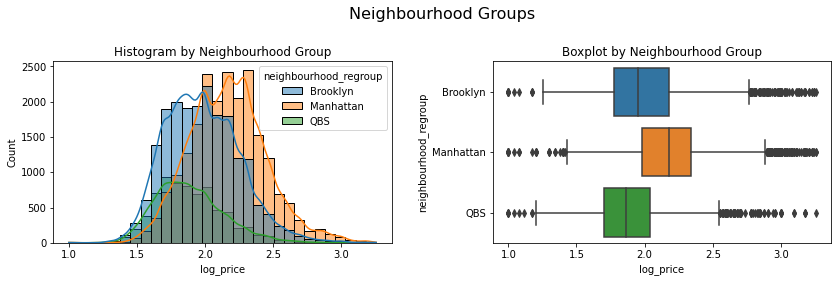

In [ ]:
plt.figure(figsize = (13.5,4.2))
plt.suptitle('Neighbourhood Groups', fontsize=16)

plt.subplots_adjust(left=0.1,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.8, 
                    wspace=0.3, 
                    hspace=0.4)

plt.subplot(1,2,1)
sns.histplot(data=df_airbnb, x='log_price', hue='neighbourhood_regroup', 
             alpha=.5, bins=30, kde=True)
plt.title('Histogram by Neighbourhood Group')

plt.subplot(1,2,2)
sns.boxplot(data=df_airbnb, x='log_price', y='neighbourhood_regroup')
plt.title('Boxplot by Neighbourhood Group')
plt.show()

In [ ]:
round(df_airbnb.groupby(['neighbourhood_regroup'])['log_price'].describe(),2)

,count,mean,std,min,25%,50%,75%,max
neighbourhood_regroup,,,,,,,,
Brooklyn,20070.0,1.98,0.27,1.0,1.78,1.95,2.18,3.26
Manhattan,21575.0,2.17,0.28,1.0,1.98,2.18,2.34,3.26
QBS,7122.0,1.89,0.26,1.0,1.70,1.86,2.04,3.26


#### Checking Test Assumptions

Simply, the F-test has three main assumptions:
1.  Independence 
2.  Normality
3.  Homogenous Variance

##### 1. Independence

> Again, we will assume that the assumption for independence is satisfied -- One rental price would not influence other rental prices. 

##### 2. Normality

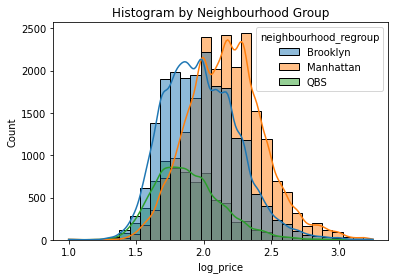

In [ ]:
#histogram by neighbourhood group
sns.histplot(data=df_airbnb, x='log_price', hue='neighbourhood_regroup', 
             alpha=.5, bins=30, kde=True)
plt.title('Histogram by Neighbourhood Group')
plt.show()

- From the histograms, each neighborhood group appears approximately normally distributed.

In [ ]:
#calculate skew, kurt for each neighbourhood group

#initialize
unique_neighbourhoods = df_airbnb['neighbourhood_regroup'].unique()
neighbourhood_skew = []
neighbourhood_kurt = []

#skew/kurt for each neighbourhood
for neighbourhood in unique_neighbourhoods:
  neighbourhood_skew.append(
      stats.describe(
          df_airbnb[df_airbnb['neighbourhood_regroup'] == neighbourhood]
          ['log_price'])[4]
          ) 
  neighbourhood_kurt.append(
      stats.describe(
          df_airbnb[df_airbnb['neighbourhood_regroup'] == neighbourhood]
          ['log_price'])[5])

#round each element in a list
round_skew = [round(skew, 3) for skew in neighbourhood_skew]
round_kurt = [round(kurt, 3) for kurt in neighbourhood_skew]

print('Neighbourhoods:{}'.format(unique_neighbourhoods))
print('Skew, by Neighbourhood: {}'.format(round_skew))
print('Kurtosis, by Neighbourhood: {}'.format(round_kurt))

Neighbourhoods:['Brooklyn' 'Manhattan' 'QBS']
Skew, by Neighbourhood: [0.503, 0.293, 0.698]
Kurtosis, by Neighbourhood: [0.503, 0.293, 0.698]


- The suggested rule of thumb that $|Skew| < 3$  and $|Kurtosis| < 8$ are both satisfied for each group

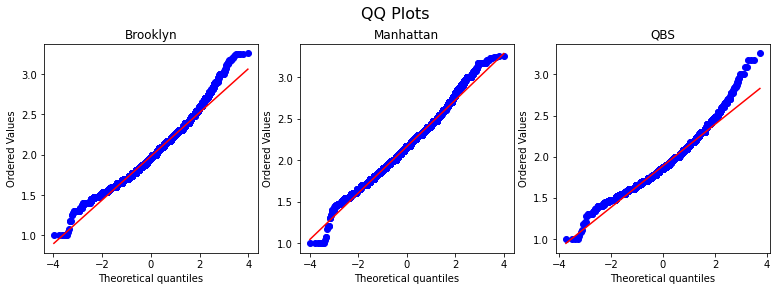

In [ ]:
#qq plot by neighbourhood
plt.figure(figsize = (13,4))
plt.suptitle('QQ Plots', fontsize=16)

plt.subplots_adjust(
    top=0.85
    )

for i, neighbourhood in enumerate(unique_neighbourhoods):
  plt.subplot(1,3,i+1)
  stats.probplot(
      df_airbnb[
                df_airbnb['neighbourhood_regroup'] == neighbourhood
                ]
                 ['log_price'], dist="norm", plot=plt)
  plt.title(neighbourhood)

- Again, a QQ plot would follow the red 45-degree line for a theoretically normal distribution
- Each group appears to be approximately normal except for the tails of the distribution. The group `QBS` seems to deviate the most from normality in the right tail. This deviation makes sense because of the right-skew in the histogram.  



In future work, we could formally test for normality using the tests Shapiro–Wilk (SW) and Anderson-Darling (AD), just like in Research Question 1.


##### 3. Homogeneous Variance


We will formally test for equality of variance across groups with two tests:

- Barlett's test
- Levene test

In [ ]:
#Bartlet's test
bartletttest = stats.bartlett(
    df_airbnb[df_airbnb['neighbourhood_regroup'] == 'Manhattan']['log_price'],
    df_airbnb[df_airbnb['neighbourhood_regroup'] == 'Brooklyn']['log_price'],
    df_airbnb[df_airbnb['neighbourhood_regroup'] == 'QBS']['log_price']
)

print("Statistic is {:.2f} with a p-value of {:.5f}".format(
    bartletttest.statistic, bartletttest.pvalue))

Statistic is 90.57 with a p-value of 0.00000


In [ ]:
#Levene test
#Less senstive to departures from normalitiy than bartlett
levenetest = stats.levene(
    df_airbnb[df_airbnb['neighbourhood_regroup'] == 'Manhattan']['log_price'],
    df_airbnb[df_airbnb['neighbourhood_regroup'] == 'Brooklyn']['log_price'],
    df_airbnb[df_airbnb['neighbourhood_regroup'] == 'QBS']['log_price']
)

print("Statistic is {:.2f} with a p-value of {:.5f}".format(
    levenetest.statistic, levenetest.pvalue))

Statistic is 47.19 with a p-value of 0.00000


For both the Barlett's and Levene test, we reject the null hypothesis that the variance across groups is equal. Thus, a violation of the assumption of homogeneous variance. In future work, I would explore the details of these tests for large sample sizes. For now, I will continue with the F-test.

####Parametric Tests

######F-test

In [ ]:
ftest = stats.f_oneway(
    df_airbnb[df_airbnb['neighbourhood_regroup'] == 'Manhattan']['log_price'],
    df_airbnb[df_airbnb['neighbourhood_regroup'] == 'Brooklyn']['log_price'],
    df_airbnb[df_airbnb['neighbourhood_regroup'] == 'QBS']['log_price']
)

In [ ]:
print("F Statistic is {:.2f} with a p-value of {:.5f}".format(
    ftest.statistic, ftest.pvalue))

F Statistic is 3793.74 with a p-value of 0.00000


- We reject the null hypothesis that the average log rental prices are equal in each neighbourhood. Intuitively, this is what we expected. 

######Tukey Pairwise Comparison

We have confirmed that *at least one* of the three neighbourhood group rental prices differ significantly from the others. So next, I want to compare each neighbourhood group pairwise to see which groups are significantly different. 

The group comparisons are: 
- Brooklyn vs. Manhattan
- Brooklyn vs. QBS
- Manhattan vs. QBS

I will accomplish this by using the Tukey Pairwise Comparison to control for Type I error.

In [ ]:
tukey = pairwise_tukeyhsd(
    endog = df_airbnb['log_price'],               #data
    groups = df_airbnb['neighbourhood_regroup'],  #groups
    alpha = 0.05)                                 #significance level

In [ ]:
print(tukey)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj  lower   upper  reject
---------------------------------------------------------
 Brooklyn Manhattan   0.1847 0.001  0.1784   0.191   True
 Brooklyn       QBS  -0.0929 0.001 -0.1018  -0.084   True
Manhattan       QBS  -0.2776 0.001 -0.2864 -0.2688   True
---------------------------------------------------------


- We reject the null hypothesis that the average rental log price is the same for each of the three neighbourhood group comparisons. 

Thus, the average rental price is significantly different for all neighbourhood groups.

####Non-parametric Tests

Next, since we formally rejected the assumption of normality and equality of variance for the F-test, we will consider two non-parametric tests:

1.   Kruskal-Wallis
2.   Median Test


In [ ]:
#KW
kruskaltest = stats.kruskal(
    df_airbnb[df_airbnb['neighbourhood_regroup'] == 'Manhattan']['log_price'],
    df_airbnb[df_airbnb['neighbourhood_regroup'] == 'Brooklyn']['log_price'],
    df_airbnb[df_airbnb['neighbourhood_regroup'] == 'QBS']['log_price']
)
print("The KW test statistic is {:.2} with a p-value of {:.5}.".format(
    kruskaltest.statistic, kruskaltest.pvalue))

The KW test statistic is 7e+03 with a p-value of 0.0.


We reject the null hypothesis; thus, one sample stochastically dominates another sample. 

In [ ]:
#Median Test
stat, p, med, tbl = stats.median_test(
    df_airbnb[df_airbnb['neighbourhood_regroup'] == 'Manhattan']['log_price'],
    df_airbnb[df_airbnb['neighbourhood_regroup'] == 'Brooklyn']['log_price'],
    df_airbnb[df_airbnb['neighbourhood_regroup'] == 'QBS']['log_price']
    )
print("The Median test statistic is {:.2} with a p-value of {:.5}.".
      format(stat, p))

The Median test statistic is 4.9e+03 with a p-value of 0.0.


We reject the null hypothesis that the three group medians come from populations with an equal median (log) price.


We confirmed our intuition with the two non-parametric tests; the prices for rentals in the three neighbourhood groups are significantly different.

#### Summary

Our findings for the comparisons of neighbourhood groups are as follows: 

- F-Test: At least one group significantly different
- Tukey Pairwise Comparsion: All groups are significantly different
- KW Test: Samples are significantly different
- Median Test: Medians are significantly different 

The results make intuitive sense because, recall, the distributions for the three neighbourhood groups visually look different in the histogram below.

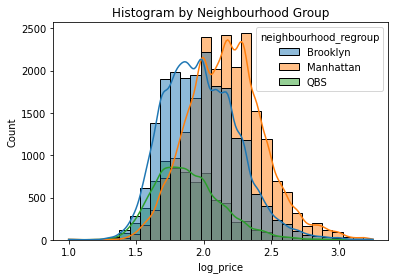

In [ ]:
#histogram by neighbourhood group
sns.histplot(data=df_airbnb, x='log_price', hue='neighbourhood_regroup', 
             alpha=.5, bins=30, kde=True)
plt.title('Histogram by Neighbourhood Group')
plt.show()

### Research Question 3: Comparison of Neighbourhood Groups and Room Type *Combinations*

#### Introduction

So far, we have discovered that average rental Airbnb prices are significantly different for:
*   Different room types
*   Different neighbourhood groups

Let's continue with a cross-comparison for different room types and neighbourhood combinations.

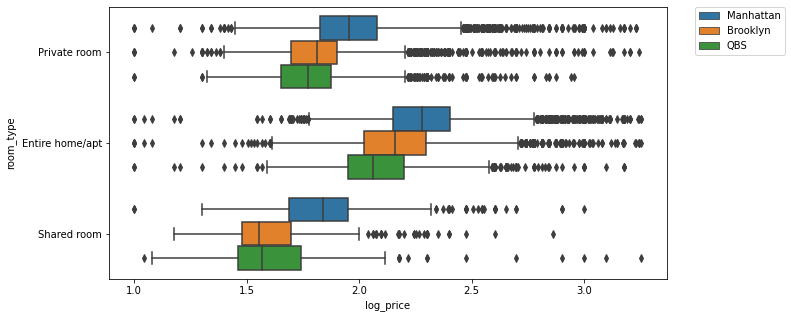

In [ ]:
#boxplot for neighbourhood groups and room types
plt.figure(figsize=(10,5))
sns.boxplot(data=df_airbnb, y='room_type', x="log_price", 
                 hue='neighbourhood_regroup', 
                 hue_order = ['Manhattan', 'Brooklyn', 'QBS'], 
                 order = ['Private room', "Entire home/apt", "Shared room"], 
                 orient='h')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
#mean log price by neighbourhood and room type
print('Average log price \n', 
      round(
          df_airbnb.groupby(
              ['room_type', 'neighbourhood_regroup']
              )['log_price'].mean(),3)
      )

Average log price 
 room_type        neighbourhood_regroup
Entire home/apt  Brooklyn                 2.172
                 Manhattan                2.297
                 QBS                      2.088
Private room     Brooklyn                 1.817
                 Manhattan                1.969
                 QBS                      1.779
Shared room      Brooklyn                 1.615
                 Manhattan                1.849
                 QBS                      1.635
Name: log_price, dtype: float64


In [ ]:
#create new column for combination of neighbourhood groups and room types
df_airbnb['neighbourhood_roomtype'] = df_airbnb["neighbourhood_regroup"] \
                                        + "/" + df_airbnb["room_type"]

In [ ]:
print('neighbourhood_groups/room type combinations:')
print(df_airbnb['neighbourhood_roomtype'].unique(),'\n')
print('counts:')
print(df_airbnb.groupby('neighbourhood_roomtype').size())

neighbourhood_groups/room type combinations:
['Brooklyn/Private room' 'Manhattan/Entire home/apt'
 'Manhattan/Private room' 'Brooklyn/Entire home/apt'
 'Manhattan/Shared room' 'QBS/Private room' 'QBS/Entire home/apt'
 'QBS/Shared room' 'Brooklyn/Shared room'] 

counts:
neighbourhood_roomtype
Brooklyn/Entire home/apt      9540
Brooklyn/Private room        10119
Brooklyn/Shared room           411
Manhattan/Entire home/apt    13125
Manhattan/Private room        7970
Manhattan/Shared room          480
QBS/Entire home/apt           2647
QBS/Private room              4208
QBS/Shared room                267
dtype: int64


#### Testing

To compare each room type and neighbourhood combination, I will use the Tukey Pairwise Comparison to control for Type I error. 

In [ ]:
tukey2 = pairwise_tukeyhsd(
    endog=df_airbnb['log_price'],                 # Data
    groups = df_airbnb['neighbourhood_roomtype'], # Groups
    alpha = 0.05)                                  #Significance level

In [ ]:
print(tukey2)

                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
          group1                    group2          meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------
 Brooklyn/Entire home/apt     Brooklyn/Private room  -0.3552  0.001 -0.3646 -0.3457   True
 Brooklyn/Entire home/apt      Brooklyn/Shared room  -0.5565  0.001   -0.59  -0.523   True
 Brooklyn/Entire home/apt Manhattan/Entire home/apt   0.1252  0.001  0.1163  0.1342   True
 Brooklyn/Entire home/apt    Manhattan/Private room  -0.2023  0.001 -0.2124 -0.1922   True
 Brooklyn/Entire home/apt     Manhattan/Shared room  -0.3226  0.001 -0.3537 -0.2915   True
 Brooklyn/Entire home/apt       QBS/Entire home/apt  -0.0839  0.001 -0.0985 -0.0693   True
 Brooklyn/Entire home/apt          QBS/Private room  -0.3927  0.001  -0.405 -0.3804   True
 Brooklyn/Entire home/apt           QBS/Shared room  -0.5372  0.001 -0.5784 -0.4959   True

- All pairwise comparisons reject the null hypothesis, except for Shared rooms in Brooklyn vs. QBS.

#### Example Comparisons

##### Shared rooms in Brooklyn vs. QBS

Consider the comparison that did not reject the null; shared rooms in Brooklyn and QBS.

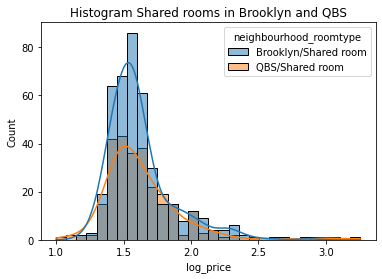

In [ ]:
#histogram by shared room for Brooklyn and QBS 
sns.histplot(data=df_airbnb, x='log_price', hue='neighbourhood_roomtype',
             hue_order = ['Brooklyn/Shared room', 'QBS/Shared room'],
             alpha=.5, bins=30, kde=True)
plt.title('Histogram Shared rooms in Brooklyn and QBS')
plt.show()

- There is no significant difference in the average Airbnb rental price for a shared room in Brooklyn or QBS. 

These results could be helpful in the scenario that a traveler was flexible on location and had a small budget. They could quickly know that there isn't a significant difference in (log) prices outside of Manhattan for shared rooms. These results could help a traveler make a more informed decision quickly.

##### Private Brooklyn room vs. Shared Manhattan room

From the Tukey pair-wise comparison, there was a significant difference in the mean log transformation of prices for a private room in Brooklyn and a shared room in Manhattan. However, it was rejected with the largest `pvalue`.  

Let's suppose a traveler is on a budget but is not sure whether they would prefer more privacy or better proximity to the heart of the city. They may be deciding between a shared room in Manhattan or a private room in Brooklyn.

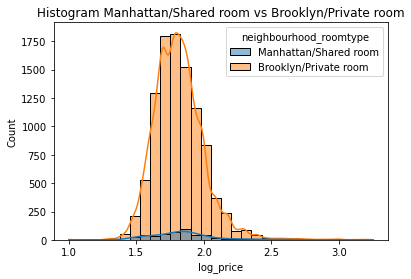

In [ ]:
#histogram for Manhattan/Shared room and  Brooklyn/Private room
#mean for Manhattan/shared room
sns.histplot(data=df_airbnb, x='log_price', hue='neighbourhood_roomtype',
             hue_order = ['Manhattan/Shared room', 'Brooklyn/Private room'],
             alpha=.5, bins=30, kde=True)
plt.title('Histogram Manhattan/Shared room vs Brooklyn/Private room')
plt.show()

Note that the sample size for "Brooklyn/Private room" is substantially smaller than the sample size for Manhattan. In this case, a t-test is still valid, but if the sample sizes are uneven, unequal variances can greatly influence the Type 1 error rate of the t-test. 

Define:
- Group 1: Brooklyn/Private room 
- Group 2: Manhattan/Shared room

In [ ]:
ci = get_ci(df_airbnb[df_airbnb['neighbourhood_roomtype'] == 
              'Brooklyn/Private room']['log_price'], 
            df_airbnb[df_airbnb['neighbourhood_roomtype'] == 
              'Manhattan/Shared room']['log_price'], 95)
print(ci)


        The difference in means for the log transformed data at the 95% 
        confidence interval is between 0.015 and 0.050. 
 

        The geometric mean price of Group 1 is 1.078 times as much as 
        Group 2 (95% CI: 1.035 to 1.122 times as much). 

        


With the confidence interval, we can provide more information for the traveler about *how much* more they would expect to pay for privacy, but being farther away from Manhattan.

#### Confidence Intervals for each pairwise comparison

Next, we will calculate the confidence interval for each room type/neighbourhood comparison.

With these confidence intervals, a traveler could use this information to know how much more expensive one group could be than the other on average. They could then weigh the pros and cons of their needs for privacy and need for proximity to the city, considering their budget. 

In [ ]:
#function to calculating (ci_perc)% CI for a difference between two means
#transformed back into ratio of geometric means
#simplifed output
#ci_perc: (0,100), typically 90 or 95

def simple_get_ci(array_1, array_2, ci_perc):
    n1 = array_1.shape[0] #sample size array_1
    n2 = array_2.shape[0] #sample size array_2

    mu1 = array_1.mean() 
    mu2 = array_2.mean() 

    var1 = array_1.var() 
    var2 = array_2.var() 
    
    mu_diff = mu2 - mu1 
    
    #pooled estimate of the common standard deviation 
    std_pooled = math.sqrt((((n1 - 1)*var1) + ((n2 - 1)*var2)) / (n1 + n2 - 2))

    alpha = 1 - (ci_perc/100) #significance level
    df = n1 + n2 - 2 #degrees of freedom
    t_crit = stats.t.ppf((1 - (alpha/2)), df)
    
    margin_err = t_crit*std_pooled*math.sqrt(n1**-1 + n2**-1)

    ci_lower = mu_diff - margin_err
    ci_upper = mu_diff + margin_err

    ratio_lower = 10**ci_lower
    ratio_upper = 10**ci_upper
    ratio_mudiff = 10**mu_diff
    
    return("{:.0f} ({:.3f}, {:.3f})".format(
            ci_perc, ratio_lower, ratio_upper))

In [ ]:
#9 total combinations; 3 room types and 3 neighbourhood groups
groups = df_airbnb['neighbourhood_roomtype'].unique()
print(groups)

['Brooklyn/Private room' 'Manhattan/Entire home/apt'
 'Manhattan/Private room' 'Brooklyn/Entire home/apt'
 'Manhattan/Shared room' 'QBS/Private room' 'QBS/Entire home/apt'
 'QBS/Shared room' 'Brooklyn/Shared room']


In [ ]:
#get combinations of pairwise comparison for 9 groups
#36 combinations total
combo_groups = list(combinations(groups,2))

#example
print(combo_groups[0][0])
print(combo_groups[0][1])

Brooklyn/Private room
Manhattan/Entire home/apt


In [ ]:
#example: Get CI for Brooklyn/Private Room vs Manhattan/Entire home
group1 = df_airbnb[df_airbnb["neighbourhood_roomtype"] == 
                   combo_groups[0][0]]['log_price']
group2 = df_airbnb[df_airbnb["neighbourhood_roomtype"] == 
                   combo_groups[0][1]]['log_price']

In [ ]:
ci = simple_get_ci(group1, group2, 95)
print("{}: {}, {}".format(ci, combo_groups[0][0], combo_groups[0][1]))

95 (2.985, 3.061): Brooklyn/Private room, Manhattan/Entire home/apt


In [ ]:
#get CI for all combination of groups
ci_list = [] #initialize

for i in range(len(combo_groups)):
    #print("This is i: {}".format(i))
    group1 = df_airbnb[df_airbnb["neighbourhood_roomtype"] == combo_groups[i][0]]['log_price']
    group2 = df_airbnb[df_airbnb["neighbourhood_roomtype"] == combo_groups[i][1]]['log_price']
    #print("These are the groups: {} {}".format(combo_groups[i][0], combo_groups[i][1]))
    ci_list.append(simple_get_ci(group1, group2, 95))

#print confidence interval along with group names
ci_list_with_groups = "\n".join("{} {}"
                                .format(x,y) for x, y in zip(
                                    ci_list, combo_groups))
print(ci_list_with_groups)

95 (2.985, 3.061) ('Brooklyn/Private room', 'Manhattan/Entire home/apt')
95 (1.402, 1.442) ('Brooklyn/Private room', 'Manhattan/Private room')
95 (2.236, 2.295) ('Brooklyn/Private room', 'Brooklyn/Entire home/apt')
95 (1.035, 1.122) ('Brooklyn/Private room', 'Manhattan/Shared room')
95 (0.903, 0.932) ('Brooklyn/Private room', 'QBS/Private room')
95 (1.832, 1.904) ('Brooklyn/Private room', 'QBS/Entire home/apt')
95 (0.623, 0.694) ('Brooklyn/Private room', 'QBS/Shared room')
95 (0.602, 0.657) ('Brooklyn/Private room', 'Brooklyn/Shared room')
95 (0.464, 0.477) ('Manhattan/Entire home/apt', 'Manhattan/Private room')
95 (0.739, 0.760) ('Manhattan/Entire home/apt', 'Brooklyn/Entire home/apt')
95 (0.340, 0.374) ('Manhattan/Entire home/apt', 'Manhattan/Shared room')
95 (0.298, 0.309) ('Manhattan/Entire home/apt', 'QBS/Private room')
95 (0.605, 0.631) ('Manhattan/Entire home/apt', 'QBS/Entire home/apt')
95 (0.204, 0.232) ('Manhattan/Entire home/apt', 'QBS/Shared room')
95 (0.198, 0.219) ('Manha

# Future Considerations

In the future, I would like to explore:
-  Different cities
-  More current data

Ideally, it would be nice to explore not only room type but also have data on the size, perhaps in square feet, or each rental.

Given more time, it would be interesting to look into column `minimum_nights` to explore the effect of long-term vs. short-term rentals on the rental price.